<a href="https://colab.research.google.com/github/HoseinNekouei/sentiment_analysis/blob/main/text_aspect_generation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libreries and important requirment**

In [ ]:
!pip install datasets

In [12]:
# Standard library imports
import os
import re
import logging
from typing import Optional
from google.colab import output
from google.colab import userdata

# Third-party library imports
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from typing import Optional
from datasets import Dataset

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

userdata.get('HF_TOKEN')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Load Dataset and Pre-Processing data**

In [4]:
# visualize Data variation
class DataVisualizer:
    @staticmethod
    def visualize_sentiment(data):
        sentiment_count = data.labels.value_counts()
        colors = sns.color_palette('pastel', 3)
        labels = ['Negative', 'Neutral', 'Positive']
        explode = [0.01, 0.01, 0.01]

        plt.figure(figsize=(4, 4))
        sentiment_count.plot(
            kind='pie',
            colors=colors,
            labels=labels,
            explode=explode,
            shadow=True,
            autopct='%.2f',
            fontsize=12,
        )
        plt.title('Total Tweets for Each Sentiment')
        plt.ylabel(' ')
        plt.show()

In [5]:
class TextProcessor:
    @staticmethod
    def class_mapping(sentiment: str)-> int:
        """ Map class labels to new values."""
        sentiment_mapping={
            'negative': 0,
            'neutral': 1,
            'positive': 2,
        }
        return sentiment_mapping.get(sentiment, -1)

    # Remove url
    @staticmethod
    def remove_urls(text):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)

    # Remove html
    @staticmethod
    def remove_html(text):
        html=re.compile(r'<.*?>')
        return html.sub(r'',text)

    # Decontraction text
    @staticmethod
    def decontraction(text):
        contractions = {
            r"won\'t": " will not",
            r"won\'t've": " will not have",
            r"can\'t": " can not",
            r"don\'t": " do not",
            r"didn\'t": " did not",
            r"can\'t've": " can not have",
            r"ma\'am": " madam",
            r"let\'s": " let us",
            r"ain\'t": " am not",
            r"shan\'t": " shall not",
            r"sha\n't": " shall not",
            r"o\'clock": " of the clock",
            r"y\'all": " you all",
            r"n\'t": " not",
            r"n\'t've": " not have",
            r"\'re": " are",
            r"\'s": " is",
            r"\'d": " would",
            r"\'d've": " would have",
            r"\'ll": " will",
            r"\'ll've": " will have",
            r"\'t": " not",
            r"\'ve": " have",
            r"\'m": " am",
            r"\'re": " are",
        }
        for pattern, replacement in contractions.items():
            text = re.sub(pattern, replacement, text)
        return text

    @staticmethod
    def normalize_repeated_chars(text):
        # Preserve ellipses by temporarily replacing them with a unique placeholder
        placeholder = "<ELLIPSIS>"
        text = re.sub(r'\.{3,}', placeholder, text)  # Replace ellipses with a placeholder
        # Normalize repeated characters. Matches any character repeated 3 or more times like cooool -> cool
        text = re.sub(r'(.)\1{2,}', r'\1', text)
        # Restore ellipses by replacing the placeholder with '...'
        text = text.replace(placeholder, '...')
        return text

In [6]:
class DatasetLoader:
    def __init__(self, *, file_path: str, nrows= 100):
        self.file_path: str = file_path
        self._data: Optional[pd.DataFrame] = None
        self.nrows= nrows

    def loader(self) -> pd.DataFrame:
        if not os.path.exists(self.file_path):
            logging.error(f"File not found: {self.file_path}")
            raise FileNotFoundError(f"File not found: {self.file_path}")
        try:
            self._data = pd.read_csv(self.file_path, nrows= self.nrows)
            logging.info("Data loaded successfully.")
        except Exception as e:
            logging.error(f"Error loading data: {e}")
            raise
        return self._data

    def visualize_data(self)-> pd.DataFrame:
        if self._data is None:
            raise ValueError("Data not loaded. Call `loader()` first.")
        DataVisualizer.visualize_sentiment(self._data)
        return self._data

    def map_classes(self)-> pd.DataFrame:
        if self._data is None:
            raise ValueError("Data not loaded. Call `loader()` first.")
        self._data['labels'] = self._data['labels'].apply(TextProcessor.class_mapping)
        return self._data

    def text_preprocessing(self)-> pd.DataFrame:
        if self._data is None:
            raise ValueError("Data not loaded. Call `loader()` first.")

        # Apply the static method to remove html
        self._data['revised_text']= self._data['text'].apply(TextProcessor.remove_html)
        # Apply the static method to remove urls
        self._data['revised_text']= self._data['revised_text'].apply(TextProcessor.remove_urls)
        # Apply the static method to decontract text.
        self._data['revised_text']= self._data['revised_text'].apply(TextProcessor.decontraction)
        # Convert texts to lowercase.
        self._data['revised_text']= self._data['revised_text'].apply(lambda x: x.lower())
        # Replace Repeated Characters with a Single Instance
        self._data['revised_text']= self._data['revised_text'].apply(TextProcessor.normalize_repeated_chars)

    def __str__(self):
        if self._data is None:
            return "Data not loaded."
        information = [
            f'Categories of : {self._data.labels.value_counts().to_dict()}',
            f'\nInformation: {self._data.info()}'
        ]
        return ', '.join(information)

    def __call__(self)-> pd.DataFrame:
        self.loader()
        self.visualize_data()
        self.map_classes()
        self.text_preprocessing()
        return self._data


# **Generate aspect of each text by text2text generation LLM**

In [7]:
from transformers import T5ForConditionalGeneration, T5TokenizerFast

class AspectGeneration:
    def __init__(self, *, model_name, texts, batch_size=128, prompt):
        self.model_name = model_name
        self.texts = texts
        self.batch_size = batch_size
        self.prompt = prompt
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = None
        self.tokenizer = None

    def load_model(self):
        """Load the T5 model and tokenizer."""
        self.model = T5ForConditionalGeneration.from_pretrained(self.model_name, device_map='auto', torch_dtype=torch.float16)
        self.tokenizer = T5TokenizerFast.from_pretrained(self.model_name)
        self.model.to(self.device)

    def text_augmentation(self):
        """Generate augmented texts using the T5 model."""
        augmented_texts = []

        for i in range(0, len(self.texts), self.batch_size):
            batch = self.texts[i:i + self.batch_size]
            prompts = [self.prompt + text for text in batch]

            # Tokenize and generate
            inputs = self.tokenizer(
                prompts,
                return_tensors='pt',
                padding=True,
                truncation=True
            ).to(self.device)

            outputs = self.model.generate(
                **inputs,
                max_length=50,
                num_return_sequences=1
            )

            # Decode and combine
            generated_texts = self.tokenizer.batch_decode(outputs, skip_special_tokens=True)

            print(f'Generated {i}/{len(self.texts)} texts')

            for original_text, generated_text in zip(batch, generated_texts):
                augmented_texts.append(f"{original_text} [START_ASPECT] {generated_text} [END_ASPECT]")

        return augmented_texts


    def create_dataset(self, augmented_texts, labels=None, save_path=None):

        dataset_dict = {"text": augmented_texts}
        if labels is not None:
            dataset_dict["labels"] = labels

        # Create a Hugging Face Dataset
        dataset = Dataset.from_dict(dataset_dict)

        # Convert to Pandas DataFrame
        df = pd.DataFrame(dataset_dict)

        # Save to CSV if a save path is provided
        if save_path:
            try:
                df.to_csv(save_path, index=False)
                print(f"Dataset saved successfully to {save_path}")
            except Exception as e:
                print(f"Error saving dataset to {save_path}: {e}")

        return dataset, df

    def __call__(self, labels=None, save_path=None):
        self.load_model()
        augmented_texts = self.text_augmentation()

        if labels is not None:
            dataset, df = self.create_dataset(augmented_texts, labels, save_path)
            return augmented_texts, dataset, df
        else:
            return augmented_texts

#**Useing File**

fatal: destination path 'sentiment_analysis' already exists and is not an empty directory.


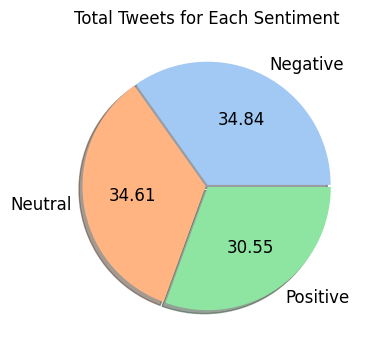

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52000 entries, 0 to 51999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            52000 non-null  object
 1   labels          52000 non-null  int64 
 2   negativereason  18117 non-null  object
 3   positivereason  17997 non-null  object
 4   revised_text    52000 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.0+ MB
Categories of : {0: 18117, 2: 17997, 1: 15886}, 
Information: None


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Generated 0/52000 texts
Generated 512/52000 texts


In [ ]:
if __name__ == "__main__":
    !git clone 'https://github.com/HoseinNekouei/sentiment_analysis.git'
    file_path= '/content/sentiment_analysis/balanced_dataset_US_airline_Tweet.csv'

    loader= DatasetLoader(file_path= file_path, nrows= 52000)
    loader() # Load, visualize, map classes, and preprocess data
    print(loader)

    texts= loader._data['text']
    labels= loader._data['labels']

    batch_size= 512
    model_name = "google/flan-t5-large"
    prompt = "Provide a brief explanation the interpretation of the key emotional aspects and tone: "

    aspect_generator = AspectGeneration(model_name=model_name, batch_size= batch_size, texts=texts, prompt=prompt)
    augmented_texts = aspect_generator()

    save_path="/content/sentiment_analysis/twitter_train_corpus.csv"
    # Generate augmented texts and create dataset
    augmented_texts, dataset, df = aspect_generator(labels=labels, save_path= save_path )

    # Print results
    print("Augmented Texts:")
    [print(text) for text in augmented_texts[:5]]

    print("\nHugging Face Dataset:")
    print(dataset)

    print("\nPandas DataFrame:")
    print(df.info())